In [1]:
!pip3 install lxml
#import all tools for project
import requests
import pandas as pd
from bs4 import BeautifulSoup
import json
import numpy as np
import datetime
import matplotlib.pyplot as plt
import re
from time import sleep

You are using pip version 10.0.1, however version 21.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Determining the Frequency of Gendered Language

### References
Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

Dr. Mattei, Tulane University. SimpleText Notebook. 2020. 
Bo Pang and Lillian Lee, A Sentimental Education: Sentiment Analysis Using Subjectivity Summarization Based on Minimum Cuts, Proceedings of ACL 2004.

In [2]:
#Import CSV containing mass amount of scraped reviews for analysis
reviewsByGender = pd.read_csv("./revs_gendered.csv")
reviewsByGender

,Unnamed: 0,Review,Gender
0,0,Very good,Male
1,1,"Exelent he really care about you, he is very p...",Male
2,2,Dr. A-Rahim was very knowledgeable about my lo...,Male
3,3,Horrible physician treats you like a kid. Pts ...,Female
4,4,Dr Aaberg has been a very good dr for my husba...,Male
...,...,...,...
8890,8890,Very helpful and sincere about my pain needs! ...,Male
8891,8891,"Several of my children see Dr. Zach, she is a ...",Female
8892,8892,Amazing Pediatric Neurologist stays up to date...,Female
8893,8893,Dr. Zach has been a Godsend for our daughter! ...,Female


In [3]:
# Vectorize the whole thing...
import sklearn
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


# Vectorize and play with token sizes...
vec = TfidfVectorizer(min_df = 2, 
                      max_df = 0.98, 
                      ngram_range=(1,1)) # play with min_df and max_df

reviews = reviewsByGender['Review']

# transform this into a sparse vector!
vec.fit(reviews)
tf_idf_sparse = vec.transform(reviews)
tf_idf_sparse

#only 222 unique words due to min_df 0.03 --> change to 2, maybe change to 5 (could get meaningless words)

<8895x7365 sparse matrix of type '<class 'numpy.float64'>'
	with 322903 stored elements in Compressed Sparse Row format>

In [4]:
revs = dict(zip(reviewsByGender.Review, reviewsByGender.Gender))

In [5]:
#get list of cleaned, stemmed adjectives, for later analysis. 
vect = CountVectorizer()
vect.fit(revs)
words = vect.get_feature_names()

adjectives = []
stop_words = list(set(stopwords.words('english')))

# remove stopwords 
stopped = [w for w in words if not w in stop_words]
    
# parts of speech tagging for each word 
pos = nltk.pos_tag(stopped)

# make a list of  all adjectives identified by the allowed word types list above
for w in pos:
    if w[1][0] == 'J':
        adjectives.append(w[0].lower())

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/Users/jillianbaggett/nltk_data'
    - '/Users/loaner/opt/anaconda3/nltk_data'
    - '/Users/loaner/opt/anaconda3/share/nltk_data'
    - '/Users/loaner/opt/anaconda3/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [ ]:
print(tf_idf_sparse[0, :])

In [ ]:
# We can now use this to classify the reviews!! but we need to test/train split again.

# Split..
X_train, X_test, y_train, y_test = train_test_split(tf_idf_sparse, 
                                                    reviewsByGender['Gender'], 
                                                    test_size=0.2)

In [ ]:
logisticRegr = LogisticRegression(max_iter=100000, class_weight='balanced') 
model = logisticRegr.fit(X_train, y_train)

In [ ]:
logisticRegr.classes_

In [ ]:
logisticRegr.coef_[:,0]

In [ ]:
# Make a dataframe with the words, coefficients, and classes...
recs = []

for w,i in vec.vocabulary_.items():
    recs.append([str(w)] + list(logisticRegr.coef_[:,i]))
# If we only have one class then we only get weight..
# df_weights = pd.DataFrame(tripples, columns=['word']+list(logisticRegr.classes_))
df_weights = pd.DataFrame(recs, columns=['word', 'weight'])

In [ ]:
df_weights.sort_values('weight', ascending=False)[:25]

In [ ]:
#print only adjectives
#male adjectives
maleAdjectives = df_weights[df_weights['word'].isin(adjectives)].sort_values('weight', ascending=False)[:25]


In [6]:
df_weights.sort_values('weight', ascending=True)[:25]

NameError: name 'df_weights' is not defined

In [7]:
#female adjectives
femaleAdjectives = df_weights[df_weights['word'].isin(adjectives)].sort_values('weight', ascending=True)[:25]
#maybe take out adjective specification
#vocabulary being pruned down too aggressively
femaleAdjectives

NameError: name 'df_weights' is not defined

In [8]:
# male = df_weights.sort_values('weight', ascending=False)[:10]
# female = df_weights.sort_values('weight', ascending=True)[:10]
# list_male = male['word'].values
# total_adj = np.concatenate((list_male, female['word'].values))
male = ['he','him','his','surgery','staff','man','informative','outstanding','good','kindness','arrogant']
female = ['she','her','woman','smart','detailed','felt','extremely','new']
total_adj = male + female
total_adj

['he',
 'him',
 'his',
 'surgery',
 'staff',
 'man',
 'informative',
 'outstanding',
 'good',
 'kindness',
 'arrogant',
 'she',
 'her',
 'woman',
 'smart',
 'detailed',
 'felt',
 'extremely',
 'new']

In [9]:
import gensim
import gensim.downloader as api
# Load a small word embedding model.
# Here we're using a variant called GloVe, which is trained a bit differently than we've done in class.
# https://nlp.stanford.edu/projects/glove/
# The details will not matter much for the purposes of this assignment.
w2v = api.load('glove-wiki-gigaword-50')
# see list of possible downloads here: https://github.com/RaRe-Technologies/gensim-data
print('word embeddings for %d words of dimension %d' % (len(w2v.vocab), len(w2v['love'])))

word embeddings for 400000 words of dimension 50


In [10]:
import seaborn as sns
from sklearn.decomposition import PCA
%matplotlib inline
sns.set(style="whitegrid", font_scale=1.5, rc={'figure.figsize':(12, 6)})
pd.set_option('display.max_colwidth', 100)

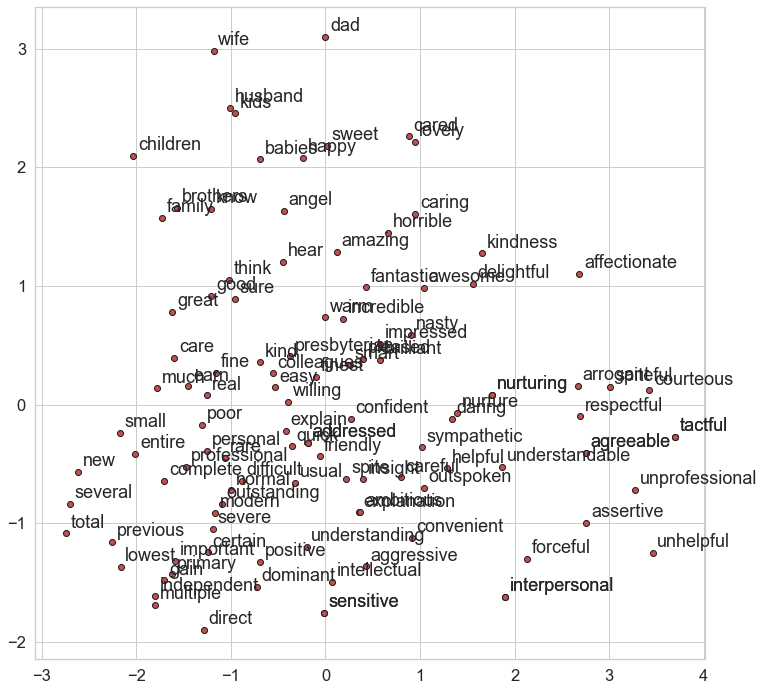

In [14]:

def plot_embeddings_w2v(w2v, words):
    word_vectors = np.array([w2v[a] for a in words])
    # reduce two 2 dimensions
    twodim = PCA(random_state=20).fit_transform(word_vectors)[:,:2]
    plt.figure(figsize=(12,12))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+.05, y+.05, word)
    plt.show()
total_adj = ['outstanding','incredible','professional','willing','finest','explanation','direct','normal','horrible','important','sure','courteous','rare','impressed','arrogant','good','easy','kindness','fine','respectful','entire','certain', 'positive','friendly','total','real','great','much','pleased','explain','severe','personal','quick','fantastic','usual','awesome','complete','unprofessional','smart','primary','sweet','poor','new','lowest','unhelpful','happy','hear','difficult','addressed','addressed','convenient','angel','understanding','previous','lovely','small','delightful','presbyterian','amazing','understandable','modern','brilliant','spite','spiteful','several','nasty','multiple','sensitive','nurturing','nurture','agreeable','interpersonal','assertive', 'confident', 'aggressive','ambitious', 'dominant', 'forceful', 'independent', 'daring', 'outspoken','intellectual', 'earn', 'gain', 'know', 'insight','think','affectionate', 'helpful', 'kind', 'sympathetic','sensitive', 'nurturing', 'agreeable', 'tactful', 'interpersonal', 'warm', 'caring','care','careful','cared','tactful','husband', 'wife', 'kids', 'babies', 'brothers', 'children','colleagues', 'dad', 'family'] 
plot_embeddings_w2v(w2v, total_adj)
# seems to be some signal separating words by sentiment.

In [12]:
#verify results
agentic_terms = ['assertive','confident','aggressive','ambitious','dominan','forceful','independent','daring','outspoken','intellectua','earn','gain','know','insight','think']
communal_terms = ['sympathetic','kind','help','affection','sensitive','nurtur','agreeab','tactful','interpersonal','warm','car','tactful']
socio_communal = ['husband','wife','kid','babies','brother','child','colleague','family']

print('Results for most commonly found female adjectives:')
print('Agentic: ', femaleAdjectives['word'].isin(agentic_terms).sum())
print('Communal: ', femaleAdjectives['word'].isin(communal_terms).sum())
print('Socio-communal: ', femaleAdjectives['word'].isin(socio_communal).sum())
print('')
print('Results for most commonly found male adjectives:')
print('Agentic: ', maleAdjectives['word'].isin(agentic_terms).sum())
print('Communal: ', maleAdjectives['word'].isin(communal_terms).sum())
print('Socio-communal: ', maleAdjectives['word'].isin(socio_communal).sum())

Results for most commonly found female adjectives:


NameError: name 'femaleAdjectives' is not defined

In [ ]:
#can use medical reviews to run with recommnedation letter reviews to predict which is which, then throw out 
#heavily medical terms

# recommendation system
# maybe seek out positive words that don't distinguish between male and female
# 4-class problem rather than two-class problem: take in star data and add pos/neg dimension to the data
# word vector stuff from NLP class: use language models and figure out how often it appears in male context vs
# female context. Ex: look at similarities between words: compare "leadership" to "man/men" 

#doubt raisers may not come out from this analysis: "she may not be the best in her class..."
# subtle, hard to catch -> maybe the word "not"
# append "not" to nearest adjective, negated adjectives might indicate doubt raisers
# hedging terms to weaken a statement (weasel words): refusing to take a stand/hesitant
# "somewhat", "mostly"

# how to rephrase it: female-correlated to neutral, remove hedging terms
# take an education based approach: "this can be conveyed as ___. If that is not your intention, consider ___"
# crowdsourcing: emphasize anonymization